## 1. 라이브러리 로드

In [ ]:
import cv2
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import tensorflow as tf
tf.random.set_seed(1)

In [ ]:
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking

In [ ]:
import os 

## 2. 이미지 데이터 확인하기

In [ ]:
dir_kaggle ='../input/face-mask-detection'
data_kaggle ='../input/face-mask-detection/dataset'
with_mask ='../input/face-mask-detection/dataset/with_mask'
without_mask='../input/face-mask-detection/dataset/without_mask'

class_data= ['with_mask','without_mask']
len_class_data = len(class_data)

In [ ]:
# from sklearn.model_selection import train_test_split
# x_train_raw, x_valid_raw, y_train_raw, y_valid_raw = train_test_split(x_train_arr, y_train_arr, stratify = y_train_arr,
#                                                                       test_size=0.25, random_state=42)
# x_train_raw.shape, x_valid_raw.shape, y_train_raw.shape, y_valid_raw.shape

In [ ]:
# # 정규화
# x_train = x_train_raw / 255
# x_valid = x_valid_raw / 255
# x_test = x_test_arr / 255

# x_train[0].max(), x_valid[0].max(), x_test[0].max()

In [ ]:
# from sklearn.preprocessing import LabelBinarizer
# lb = LabelBinarizer()
# y_train = lb.fit_transform(y_train_raw)
# y_valid = lb.transform(y_valid_raw)

In [ ]:
# lb.classes_

In [ ]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Input((height,width,3)),
#     tf.keras.applications.MobileNet(include_top=False, weights='imagenet'),
#     tf.keras.layers.Conv2D(3, 3, padding='same', activation='sigmoid'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# model.summary()

In [ ]:
image_count = {}
train_data = []

for i , class_data in tqdm(enumerate(class_data)):
    class_folder = os.path.join(data_kaggle,class_data)
    label = class_data
    image_count[class_data] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[class_data].append(class_data)
        train_data.append([f'{data_kaggle}/{class_data}/{path}', class_data])

2it [00:00, 1193.94it/s]


In [ ]:
# 각 label에 대한 빈도수
for key, value in image_count.items():
    print(f'{key}\t-> {len(value)}')

with_mask	-> 220
without_mask	-> 220


In [ ]:
# function to get an image
# 이미지 읽어오기
def read_img(filepath, size):
    # img = image.load_img(os.path.join(data_kaggle, filepath), target_size=size)
    img = image.load_img(filepath, target_size=size)
    # convert image to array
    img = image.img_to_array(img)
    return img

In [ ]:
# create a dataframe
df = pd.DataFrame(train_data, columns=['filename', 'class'])
df.head()

,filename,class
0,../input/face-mask-detection/dataset/with_mask...,with_mask
1,../input/face-mask-detection/dataset/with_mask...,with_mask
2,../input/face-mask-detection/dataset/with_mask...,with_mask
3,../input/face-mask-detection/dataset/with_mask...,with_mask
4,../input/face-mask-detection/dataset/with_mask...,with_mask


In [ ]:
df_w_mask = df[df['class']=='with_mask']
df_wo_mask = df[df['class']=='without_mask']
print(df_w_mask.shape, df_wo_mask.shape)
df_w_mask.tail()

(220, 2) (220, 2)


,filename,class
215,../input/face-mask-detection/dataset/with_mask...,with_mask
216,../input/face-mask-detection/dataset/with_mask...,with_mask
217,../input/face-mask-detection/dataset/with_mask...,with_mask
218,../input/face-mask-detection/dataset/with_mask...,with_mask
219,../input/face-mask-detection/dataset/with_mask...,with_mask


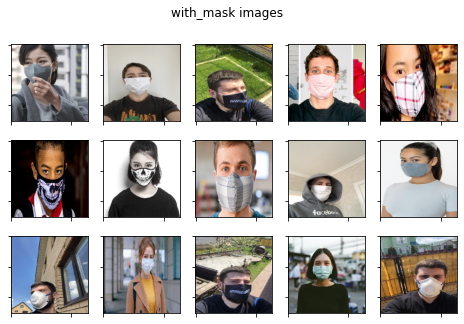

In [ ]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(8, 5));
plt.suptitle('with_mask images');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        temp_img = read_img(df_w_mask['filename'][np.random.randint(220)], (255,255))
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow(temp_img / 255.);
plt.show();

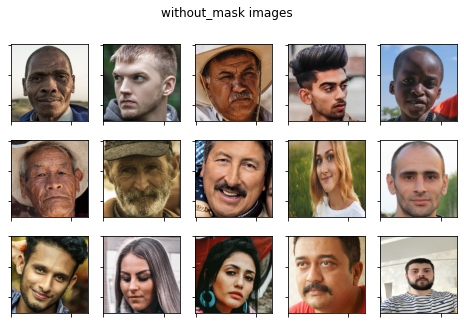

In [ ]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(8, 5));
plt.suptitle('without_mask images');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        temp_img = read_img(df_wo_mask['filename'][np.random.randint(221,440)], (255,255))
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow(temp_img / 255.);
plt.show();

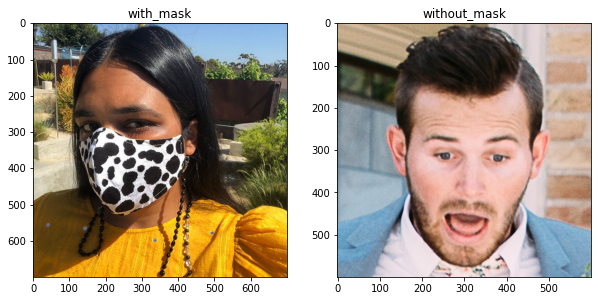

In [ ]:
# 한번에 보기
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

img_0 = plt.imread(df_w_mask['filename'][0])
axes[0].set_title('with_mask')
axes[0].imshow(img_0)

img_1 = plt.imread(df_wo_mask['filename'][221])
axes[1].set_title('without_mask')
axes[1].imshow(img_1)

## 3. train, test 데이터 분할

In [ ]:
from sklearn.model_selection import train_test_split
# train - test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify = df['class'])

# train을 다시 train + valid로 
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify = train_df['class'])

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((281, 2), (71, 2), (88, 2))

In [ ]:
train_df['class'].value_counts()

without_mask    141
with_mask       140
Name: class, dtype: int64

In [ ]:
height = 224
width = 224

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0, shear_range=0.2, zoom_range=0.2, 
                                                          rotation_range=45, horizontal_flip=True, validation_split=0.2)

In [ ]:
train_datagen = datagen.flow_from_dataframe(dataframe=train_df, target_size=(height,width), batch_size=16, 
                                    class_mode='binary', interpolation='lanczos', shuffle=True, subset='training')
val_datagen = datagen.flow_from_dataframe(dataframe=val_df, target_size=(height,width), batch_size=16, 
                                    class_mode='binary', interpolation='lanczos', shuffle=True, subset='validation')

test_datagen = datagen.flow_from_dataframe(dataframe=test_df, target_size=(height,width), batch_size=16, 
                                    class_mode='binary', interpolation='lanczos', shuffle=True)
train_datagen

Found 225 validated image filenames belonging to 2 classes.
Found 14 validated image filenames belonging to 2 classes.
Found 88 validated image filenames belonging to 2 classes.


## 4. 모델

In [ ]:
from keras import models
from keras import layers
from keras.applications.vgg16 import VGG16
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.mobilenet import MobileNet
from keras.callbacks import EarlyStopping

In [ ]:
md = MobileNet(include_top=False, pooling='max', 
                  weights='imagenet', input_shape=(height, width, 3))
md.trainable=False

md.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [ ]:
model = models.Sequential()
model.add(md)
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(patience=5)

history = model.fit(train_datagen, epochs=20, 
                    validation_data=val_datagen,
                    validation_steps=len(val_datagen),
                    callbacks = [early_stop])

Epoch 1/20
15/15 [==============================] - 12s 651ms/step - loss: 1.2062 - accuracy: 0.6222 - val_loss: 0.7996 - val_accuracy: 0.5714
Epoch 2/20
15/15 [==============================] - 9s 600ms/step - loss: 0.4961 - accuracy: 0.7867 - val_loss: 0.4688 - val_accuracy: 0.7857
Epoch 3/20
15/15 [==============================] - 9s 598ms/step - loss: 0.3306 - accuracy: 0.8667 - val_loss: 0.5965 - val_accuracy: 0.7143
Epoch 4/20
15/15 [==============================] - 9s 579ms/step - loss: 0.2029 - accuracy: 0.9111 - val_loss: 0.2078 - val_accuracy: 0.8571
Epoch 5/20
15/15 [==============================] - 9s 615ms/step - loss: 0.2053 - accuracy: 0.9289 - val_loss: 0.8624 - val_accuracy: 0.8571
Epoch 6/20
15/15 [==============================] - 9s 590ms/step - loss: 0.1563 - accuracy: 0.9422 - val_loss: 0.0916 - val_accuracy: 0.9286
Epoch 7/20
15/15 [==============================] - 9s 614ms/step - loss: 0.1320 - accuracy: 0.9556 - val_loss: 0.5931 - val_accuracy: 0.8571
Epoch

In [ ]:
score = model.evaluate(test_datagen)
score

6/6 [==============================] - 3s 510ms/step - loss: 0.1910 - accuracy: 0.9205


[0.19104374945163727, 0.9204545617103577]

In [ ]:
print(f'Accuracy : {score[1]}')

Accuracy : 0.9204545617103577


In [ ]:
##### MobileNet #####
# sigmoid
# [0.4704664349555969, 0.6931818127632141]

# relu
# [0.07068445533514023, 0.9886363744735718]
# [0.7232055068016052, 0.8863636255264282]

# adam
# [0.21423844993114471, 0.9204545617103577]

##### EfficientNetB0 #####
# [0.7435922622680664, 0.5]



In [ ]:
df_history = pd.DataFrame(history.history)
df_history

,loss,accuracy,val_loss,val_accuracy
0,1.206207,0.622222,0.799582,0.571429
1,0.496058,0.786667,0.468792,0.785714
2,0.330635,0.866667,0.596458,0.714286
3,0.202875,0.911111,0.207849,0.857143
4,0.205275,0.928889,0.862447,0.857143
5,0.156254,0.942222,0.091640,0.928571
6,0.131983,0.955556,0.593084,0.857143
7,0.080054,0.968889,0.069361,0.928571
8,0.099428,0.977778,0.075330,0.928571
9,0.121212,0.951111,0.364888,0.928571


<AxesSubplot:>

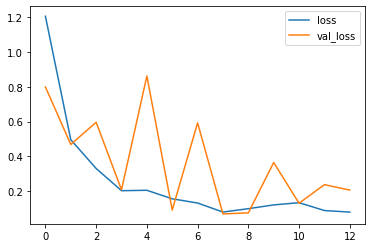

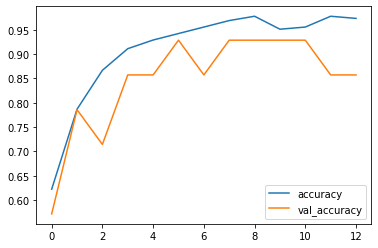

In [ ]:
df_history[['loss','val_loss']].plot()
df_history[['accuracy','val_accuracy']].plot()

## 5. 예측

In [ ]:
def predict(path) :
    img = tf.keras.preprocessing.image.load_img(path, target_size=(height,width), interpolation='lanczos')
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    pred = model.predict(np.array([img]))
    plt.imshow(img)
    if pred[0][0] > 0.5 : 
        plt.title(f'Without Mask : {pred[0][0]*100 : 0.2f}%')
    else : 
        plt.title(f'With Mask : {(1-pred[0][0])*100 : 0.2f}%')

In [ ]:
!wget https://images-na.ssl-images-amazon.com/images/I/61FakD2Mg2L._SL1280_.jpg

--2022-12-08 15:06:11--  https://images-na.ssl-images-amazon.com/images/I/61FakD2Mg2L._SL1280_.jpg
Resolving images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)... 18.65.35.175, 2a04:4e42:84::272
Connecting to images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)|18.65.35.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90983 (89K) [image/jpeg]
Saving to: ‘61FakD2Mg2L._SL1280_.jpg.2’

61FakD2Mg2L._SL1280 100%[===================>]  88.85K  --.-KB/s    in 0.1s    

2022-12-08 15:06:12 (686 KB/s) - ‘61FakD2Mg2L._SL1280_.jpg.2’ saved [90983/90983]



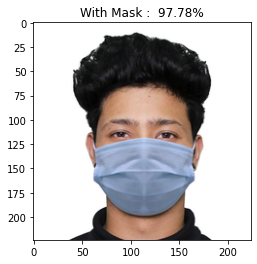

In [ ]:
predict('./61FakD2Mg2L._SL1280_.jpg')

In [ ]:
!wget https://d.newsweek.com/en/full/1202937/idris-elba.jpg

--2022-12-08 15:42:37--  https://d.newsweek.com/en/full/1202937/idris-elba.jpg
Resolving d.newsweek.com (d.newsweek.com)... 151.139.128.10
Connecting to d.newsweek.com (d.newsweek.com)|151.139.128.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494218 (483K) [image/jpeg]
Saving to: ‘idris-elba.jpg.3’

idris-elba.jpg.3    100%[===================>] 482.63K  --.-KB/s    in 0.05s   

2022-12-08 15:42:37 (9.74 MB/s) - ‘idris-elba.jpg.3’ saved [494218/494218]



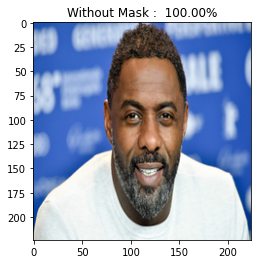

In [ ]:
predict('./idris-elba.jpg')

In [ ]:
!wget https://img.etimg.com/thumb/msid-77782370,width-650,imgsize-319096,,resizemode-4,quality-100/masks-may-protect-the-people-wearing-them-by-reducing-the-amount-of-droplets-from-others-that-might-make-contact-with-them-.jpg

--2022-12-08 15:42:38--  https://img.etimg.com/thumb/msid-77782370,width-650,imgsize-319096,,resizemode-4,quality-100/masks-may-protect-the-people-wearing-them-by-reducing-the-amount-of-droplets-from-others-that-might-make-contact-with-them-.jpg
Resolving img.etimg.com (img.etimg.com)... 69.28.187.147, 69.28.157.216, 2600:9000:2104:9e00:d:fe40:5e00:93a1, ...
Connecting to img.etimg.com (img.etimg.com)|69.28.187.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘masks-may-protect-the-people-wearing-them-by-reducing-the-amount-of-droplets-from-others-that-might-make-contact-with-them-.jpg.3’

masks-may-protect-t     [  <=>               ] 158.70K   444KB/s    in 0.4s    

2022-12-08 15:42:39 (444 KB/s) - ‘masks-may-protect-the-people-wearing-them-by-reducing-the-amount-of-droplets-from-others-that-might-make-contact-with-them-.jpg.3’ saved [162511]



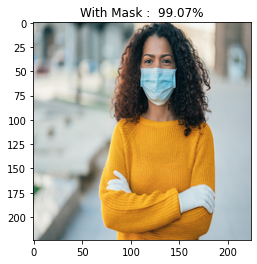

In [ ]:
predict('./masks-may-protect-the-people-wearing-them-by-reducing-the-amount-of-droplets-from-others-that-might-make-contact-with-them-.jpg')

In [ ]:
!wget https://www.biography.com/.image/ar_8:10%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cg_faces:center%2Cq_auto:good%2Cw_620/MTgwMjk3NTA4MTYzOTU0NTQw/gettyimages-1078129184.jpg

--2022-12-08 15:42:40--  https://www.biography.com/.image/ar_8:10%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cg_faces:center%2Cq_auto:good%2Cw_620/MTgwMjk3NTA4MTYzOTU0NTQw/gettyimages-1078129184.jpg
Resolving www.biography.com (www.biography.com)... 151.101.194.98, 151.101.2.98, 151.101.66.98, ...
Connecting to www.biography.com (www.biography.com)|151.101.194.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44516 (43K) [image/jpeg]
Saving to: ‘gettyimages-1078129184.jpg.3’

gettyimages-1078129 100%[===================>]  43.47K  --.-KB/s    in 0.01s   

2022-12-08 15:42:40 (4.14 MB/s) - ‘gettyimages-1078129184.jpg.3’ saved [44516/44516]



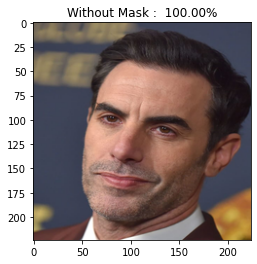

In [ ]:
predict('./gettyimages-1078129184.jpg')

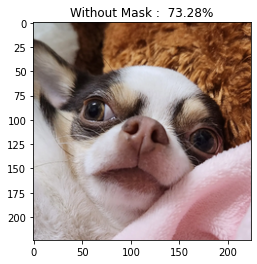

In [ ]:
# 귀여운 예티,,,
predict('../input/more-data/yeti.jpeg')

In [ ]:
model.save_weights('model_dense.h5')